In [1]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import lobpcg
#from scipy.sparse.linalg import eigsh
#from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
#from scipy import sparse
from skimage import measure         # pip install scikit-image
import torch
import plotly.graph_objects as go   # pip install plotly, nbformat

from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create a meshgrid of $x$ and $y$ coordinates

In [2]:
N = 400
initX, initY = np.mgrid[0:1:N*1j,0:1:N*1j]

Eigenstates of the Schrodinger equation satisfy $H\psi = E\psi$ where $H$ is the Hamiltonian operator, and $E$ and $\psi$ represent the eigenvalues/eigenstates. The Hamiltonian Operator in 2D is

$$H = -\frac{1}{2m}\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) + V(x,y)$$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi = E\psi$ can be arranged and rewritten in 2 dimensions as

$$\left[-\frac{1}{2}(D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

where

* $\psi$ is a vector of length $N^2$ where $N$ is the number of discretized points in $x$ and $y$
* $D$ is an $N \times N$ matrix with -2 on the main diagonal and 1 on the two neighbouring diagonals.
* $D \oplus D$: the kronecker sum of $D$ with itself so that the derivative matrix is effectively converted to operate on a "2D" vector
* $V$ is a diagonal $N^2 \times N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

Firstly, we define our potential in units of $m \Delta x^2$; in other words `get_potential` actually returns $m\Delta x^2 V$.

For example, the Kroneker sum of two $2x2$ matrices $A_{ij}$ and $B_{ij}$ is given by

$$
A \otimes B = 
\begin{bmatrix} 
a_{11} & a_{12} \\ 
a_{21} & a_{22} \\ 
\end{bmatrix} 
\otimes
\begin{bmatrix} 
b_{11} & b_{12} \\ 
b_{21} & b_{22} \\ 
\end{bmatrix} =
\begin{bmatrix} 
a_{11}+b_{11} & b_{12}        & a_{12}        & 0      \\ 
b_{21}        & a_{11}+b_{22} & 0             & a_{12} \\ 
a_{21}        & 0             & a_{22}+b_{11} & b_{12} \\ 
0             & a_{21}        & b_{21}         & a_{22}+b_{22} \\ 
\end{bmatrix} 
$$

In [3]:
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V = get_potential(initX, initY)

Now we construct

$$- \frac{1}{2} D \oplus D + m\Delta x^2 V $$

Let $T=- \frac{1}{2} D \oplus D$ and $U = m\Delta x^2 V$

In [4]:
V.reshape(N**2).shape

(160000,)

In [5]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sp.sparse.spdiags(diags, np.array([-1, 0, 1]), N, N)
T = -1./2. * sp.sparse.kronsum(D,D)
U = sp.sparse.diags(V.reshape(N**2), (0))
H = T+U

In [6]:
H

<160000x160000 sparse matrix of type '<class 'numpy.float64'>'
	with 798400 stored elements in Compressed Sparse Row format>

Convert to sparse pytorch tensor

In [7]:
# Assuming H is your Scipy sparse matrix
H = H.tocoo()
indices = torch.tensor([H.row, H.col], dtype=torch.long)
values = torch.tensor(H.data, dtype=torch.float64)  # Make sure to use the correct data type

# Create the sparse tensor
H_sparse = torch.sparse_coo_tensor(indices=indices, values=values, 
                                   size=H.shape, device=device)


/tmp/ipykernel_48245/2909941244.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  indices = torch.tensor([H.row, H.col], dtype=torch.long)


In [8]:
H_sparse

tensor(indices=tensor([[     0,      0,      0,  ..., 159999, 159999, 159999],
                       [     0,      1,    400,  ..., 159599, 159998, 159999]]),
       values=tensor([ 2.0001, -0.5000, -0.5000,  ..., -0.5000, -0.5000,
                       2.0000]),
       device='cuda:0', size=(160000, 160000), nnz=798400, dtype=torch.float64,
       layout=torch.sparse_coo)

Compute the eigenvalues and eigenvectors 

For this we will be using the [LOBPCG method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lobpcg.html). This stands for __Locally Optimal Block Preconditioned Conjugate Gradient Method__. LOBPCG is a preconditioned eigensolver for large real symmetric and complex Hermitian definite generalized eigenproblems.

In [9]:
eigenvalues, eigenvectors = lobpcg(H_sparse, k=10, largest=False)

In [10]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

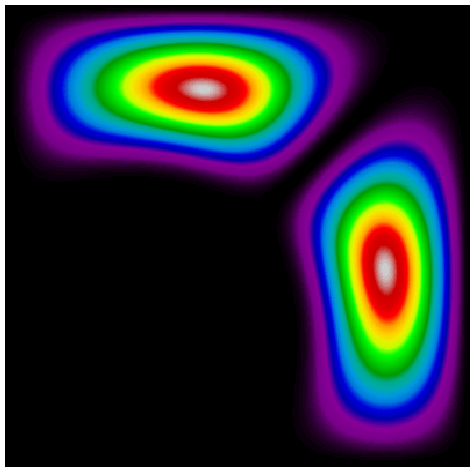

In [11]:
plt.figure(figsize=(6,6))
eigenstate = 1
plt.pcolormesh(initX, initY, get_e(eigenstate)**2, cmap='nipy_spectral')
plt.axis('off')
plt.show()

Free up some memory before performing further computation on the GPU using __lobpcg()__.

In [12]:
del initX, initY, diag, diags, D, T, U, H, H_sparse, eigenvalues, eigenvectors
torch.cuda.empty_cache()

# Moving To 3D

The hydrogen atom potential (choosing $\hbar=1$) can be expressed as

$$V(r) = -\frac{e^2}{4 \pi \epsilon_0 r} = -\frac{1}{m a_0 r}$$

and thus 

$$m \Delta x^2 V = -\frac{\Delta x^2}{a_0 r} = -\frac{(\Delta x/a_0)^2}{(r/a_0)}$$

So we'll express $\Delta x$ and $r$ in units of $a_0$

In [13]:
N = 100
X, Y, Z = np.mgrid[-25:25:N*1j, -25:25:N*1j, -25:25:N*1j] # in units of a0, 25 is good
dx = np.diff(X[:,0,0])[0] # in units of a0

Function to get hydrogen wave function potential

In [14]:
def get_potential(x, y, z):
    return -dx**2 / np.sqrt(x**2 + y**2 + z**2 + 1e-10)
V = get_potential(X, Y, Z)

In [15]:
print(V.shape, "\n", np.prod(V.shape), "\n")

(100, 100, 100) 
 1000000 



So the matrix we have to calculate has dimensions $1728000 \times 1728000$. Calculating a matrix of this size is computationally very heavy. This is why we want to use our GPU instead.

Now that we're in 3D, our matrix should be written as

$$\left[-\frac{1}{2}(D \oplus D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

In [16]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sp.sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sp.sparse.kronsum(sp.sparse.kronsum(D,D), D)
U = sp.sparse.diags(V.reshape(N**3), (0))
H = T+U

In [17]:
H.shape

(1000000, 1000000)

Convert to sparse PyTorch tensor

In [18]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device=device)

Compute eigenvalues/eigenvectors

In [19]:
# Free up some memory before performing lobpcg
del X, Y, Z, V, diag, diags, D, T, U
torch.cuda.empty_cache()

# Perform lobpcg
eigenvalues, eigenvectors = lobpcg(H, k=20, largest=False)

In [20]:
eigenvectors

tensor([[-1.0240e-12,  2.2899e-11, -2.1788e-11,  ...,  3.3992e-08,
         -7.4012e-08, -9.7380e-08],
        [ 1.0576e-12,  2.4714e-11, -3.5994e-11,  ...,  1.5585e-08,
         -1.4814e-07, -2.0842e-07],
        [-2.4454e-12,  1.8567e-11, -4.6489e-11,  ...,  3.2873e-08,
         -2.2159e-07, -3.0848e-07],
        ...,
        [ 4.1416e-11, -1.4172e-11,  2.6299e-11,  ...,  6.9096e-10,
          2.2132e-07,  3.2993e-07],
        [ 3.9420e-11, -1.0233e-11,  2.6586e-11,  ...,  2.8048e-08,
          1.4746e-07,  2.2682e-07],
        [ 2.1904e-11, -1.6404e-11,  1.5049e-11,  ...,  4.8005e-08,
          7.3651e-08,  1.2260e-07]], device='cuda:0', dtype=torch.float64)

In [21]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N,N)).cpu().numpy()

verts, faces, _, _ = measure.marching_cubes(get_e(3)**2, 1e-6, spacing=(0.1, 0.1, 0.1))
intensity = np.linalg.norm(verts, axis=1)

In [22]:
fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2], 
                                i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                intensity=intensity,
                                colorscale='Agsunset',
                                opacity=0.5)])

fig.update_layout(scene=dict(xaxis=dict(visible=False),
                              yaxis=dict(visible=False),
                              zaxis=dict(visible=False),
                              bgcolor='rgb(0, 0, 0)'),
                  margin=dict(l=0, r=0, b=0, t=0))
#fig.show()

Plot the eigenvalue Spectrum:

* The eigenvalues we found are $\mu = m \Delta x^2 E$. First we insert $\hbar$ in to make this dimensionless (no longer use the convention $\hbar=1$)  so that $\mu = m \Delta x^2 E / \hbar^2$. Then, identifying that we made $\Delta$ x in units of $a$, we insert $a$ into the expression so that $\mu = m (a \Delta x)^2 E / \hbar^2$ solving for $E$,

$$E = \frac{\hbar^2}{m \Delta x^2 a^2}$$

In [23]:
hbar = 1.055e-34
a = 5.29e-11
m = 9.11e-31
J_to_eV = 6.242e18 # convert from Joules to eV
conversion = hbar**2 / m / dx**2 / a**2 * J_to_eV 

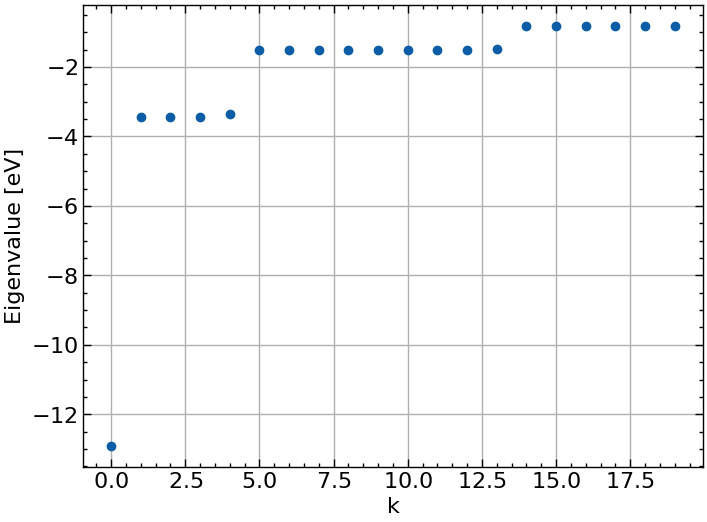

In [24]:
plt.plot(eigenvalues.cpu() * conversion, 'o')
plt.xlabel('k')
plt.ylabel('Eigenvalue [eV]')
plt.grid()

In [25]:
eigenvalues.cpu() * conversion,

(tensor([-12.9011,  -3.4333,  -3.4333,  -3.4333,  -3.3415,  -1.5215,  -1.5215,
          -1.5215,  -1.5166,  -1.5166,  -1.5166,  -1.5164,  -1.5164,  -1.4908,
          -0.8312,  -0.8167,  -0.8167,  -0.8165,  -0.8092,  -0.8092],
        dtype=torch.float64),)

In [26]:
torch.cuda.empty_cache()